# Calculation Coeta

## import

In [43]:
import math

import os
import sys

import glob

import shutil

import pandas as pd
import numpy
import numpy as np

from scipy import interpolate
from scipy import signal

import datetime

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import utils_1 as read_dcm
import utils_2 as data_utils

Drive_Train = 'Split_Axle'
# Drive_Train = '2WD'

## READ_Parameter_w_DCM
- パラメータ設定読込み

In [44]:
def READ_Parameter_w_DCM(Dcm):
    global d_PARAMETERS
    global l_PARAMETER_Honda_DMCUnitAssgin
    global l_PARAMETER_COETA
    global l_PARAMETER_COETA_2
    global l_PARAMETER_WIND
    global l_PARAMETER_MASS
    
    d_PARAMETERS = read_dcm.Read_DCM(Dcm)
    # l_PARAMETER_Honda_DMCUnitAssgin = d_PARAMETERS["FS_Honda_DMCUnitAssgin"]
    l_PARAMETER_WIND = d_PARAMETERS["Wind"]
    l_PARAMETER_MASS = d_PARAMETERS["m_DryVehicleMass"]

    if Drive_Train == 'Split_Axle':
        l_PARAMETER_COETA = d_PARAMETERS["PT_GB_CoEtaTable_AxleIndv_FA"]
        l_PARAMETER_COETA_2 = d_PARAMETERS["PT_GB_CoEtaTable_AxleIndv_RA"]
    else:
        l_PARAMETER_COETA = d_PARAMETERS["PT_GB_CoEtaTable"]
        l_PARAMETER_COETA_2 = d_PARAMETERS["PT_GB_CoEtaTable"]
    
    print(f'Wind: {l_PARAMETER_WIND}')
    print(f'm_DryVehicleMass: {l_PARAMETER_MASS}')

## Treatment Measurement
- 計測ファイルの設定

### Evaluation

In [45]:
def Evaluation(df, Sampling, Offset):
    df["Ax_vWheel"] = df["Ax_vWheel"] + Offset
    df["Ax_Sensor"] = df["Ax_Sensor"] + Offset
    
    df = Cal_Filter(df, "Ax_vWheel", "Ax_vWheel_f", 2, 0.04)
    df = Cal_Filter(df, "Ax_Sensor", "Ax_Sensor_f", 2, 0.08)
    df = Cal_Filter(df, "Ax_Model", "Ax_Model_f", 2, 0.08)
    df = Cal_Filter(df, "i_over_iDiff.FA", "i_over_iDiff.FA_f", 2, 0.5)
    df = Cal_Filter(df, "i_over_iDiff.RA", "i_over_iDiff.RA_f", 2, 0.5)

    df = Cal_Deviation(df, Sampling, "Ax_vWheel_f", "d_Ax_vWheel_f")
    df = Cal_Deviation(df, Sampling, "i_over_iDiff.FA_f", "d_i_over_iDiff.FA_f")
    df = Cal_Deviation(df, Sampling, "i_over_iDiff.RA_f", "d_i_over_iDiff.RA_f")
    
    df['Co_FA'] = df['MDrvUnitNET.FA'] / (df['MDrvUnitNET.FA'] + df['MDrvUnitNET.RA'])

    df = df.dropna(how='any')
    
    df = Cal_FxWheel_Sum(df)
    # df = Cal_Fx_from_dvxVehF_VehicleMass_AirResistance(df)
    # df = Cal_COETA(df)

    df, d_Result = Get_Evaluation_Value(df, Sampling)

    df_Result = pd.DataFrame(data=d_Result)

    return df, df_Result


# ### Coeta関係の演算信号の追加

# In[3]:

def Cal_Deviation(df, Sampling, S_in, S_out):
    iMax = len(df)

    l_Out = []

    V0 = 0

    for i in range(0, iMax):
        T = df.index[i]
        V = df.loc[df.index[i], S_in]

        Out = (V - V0) / Sampling
        l_Out.append(Out)

        V0 = V

    df[S_out] = l_Out

    return df


# ### Coeta関係の演算信号の追加

# In[3]:


def Cal_FxWheel_Sum(df):   
    l_PARAMETER_MASS = d_PARAMETERS["m_DryVehicleMass"]
    Mass = l_PARAMETER_MASS[2]
    
    # df_sum = (df["Ax_Model_f"] * df["Mass"] +
    #           df["airResistance"]) / df["CoEtaProp"]
    df_sum = (df["Ax_Model_f"] * Mass + df["airResistance"]) / (df["Co_FA"] * df["CoEtaProp.FA"] + (1 - df["Co_FA"]) * df["CoEtaProp.RA"])
    df_fa = df_sum * df["Co_FA"]
    df_ra = df_sum * (1 - df["Co_FA"])
    
    df["FxWheel_Sum"] = list(df_sum)
    df["FxWheel_FA"] = list(df_fa)
    df["FxWheel_RA"] = list(df_ra)
    
    Mass_ = np.full((1, len(df)), Mass)
    df['Mass'] = Mass_[0]

    return df

### Get_Evaluation_Value
- 保存ファイルの信号設定

In [46]:
def Get_Evaluation_Value(df, Sampling):
    Counter_Set = 10
    
    iMax = len(df)

    l_PW_Counter = []
    l_Wheel_Stable = []
    l_Ax_vWheel_Stable = []
    l_i_over_iDiff_Stable = []

    PW_Counter = 0
    Ax_vWheel_Stable = 0
    i_over_iDiff_Stable = 0

    for i in range(0, iMax):
        T = df.index[i]
        v_FL = df.loc[df.index[i], "v_FL"]
        v_FR = df.loc[df.index[i], "v_FR"]
        v_RL = df.loc[df.index[i], "v_RL"]
        v_RR = df.loc[df.index[i], "v_RR"]
        ThrottlePos = df.loc[df.index[i], "ThrottlePos"]
        d_Ax_vWheel_f = df.loc[df.index[i], "d_Ax_vWheel_f"]
        d_i_over_iDiff_FA_f = df.loc[df.index[i], "d_i_over_iDiff.FA_f"]
        d_i_over_iDiff_RA_f = df.loc[df.index[i], "d_i_over_iDiff.RA_f"]

        if ThrottlePos > 3:
            PW_Counter += 1
        else:
            PW_Counter = 0

        v_Average = (v_FL + v_FR + v_RL + v_RR) / 4

        if abs(v_FL - v_Average) < 0.3 and abs(v_FR - v_Average) < 0.3 and abs(v_RL - v_Average) < 0.3 and abs(v_RR - v_Average) < 0.3:
            Wheel_Stable = 1
        else:
            Wheel_Stable = 0

        if d_Ax_vWheel_f < 2.0 and d_Ax_vWheel_f > -2.0:
            Ax_vWheel_Stable = 1
        else:
            Ax_vWheel_Stable = 0

        if d_i_over_iDiff_FA_f < 0.1 and d_i_over_iDiff_FA_f > -0.3 and d_i_over_iDiff_RA_f < 0.1 and d_i_over_iDiff_RA_f > -0.3:
            i_over_iDiff_Stable = 1
        else:
            i_over_iDiff_Stable = 0

        l_PW_Counter.append(PW_Counter)
        l_Wheel_Stable.append(Wheel_Stable)
        l_Ax_vWheel_Stable.append(Ax_vWheel_Stable)
        l_i_over_iDiff_Stable.append(i_over_iDiff_Stable)

    df["PW_Counter"] = l_PW_Counter
    df["Wheel_Stable"] = l_Wheel_Stable
    df["Ax_vWheel_Stable"] = l_Ax_vWheel_Stable
    df["i_over_iDiff_Stable"] = l_i_over_iDiff_Stable

    l_TIME = []
    l_ThrottlePos = []
    l_i_over_iDiff_FA = []
    l_i_over_iDiff_RA = []
    # l_New_COETA_vWheel = []
    # l_New_COETA_Sensor = []
    # l_Diff_Ax_vWheel = []
    # l_Diff_Ax_Sensor = []
    l_airResistance = []
    l_FxWheel_Sum = []
    l_FxWheel_FA = []
    l_FxWheel_RA = []
    l_Ax_vWheel = []
    l_Ax_Sensor = []
    l_Ax_Model = []
    l_V = []
    l_Co_FA = []

    l_Get = []
    l_Get_Counter = []

    Get_Counter = 0

    for i in range(0, iMax):
        PW_Counter = df.loc[df.index[i], "PW_Counter"]
        Wheel_Stable = df.loc[df.index[i], "Wheel_Stable"]
        Ax_vWheel_Stable = df.loc[df.index[i], "Ax_vWheel_Stable"]
        i_over_iDiff_Stable = df.loc[df.index[i], "i_over_iDiff_Stable"]

        airResistance = df.loc[df.index[i], "airResistance"]
        FxWheel_Sum = df.loc[df.index[i], "FxWheel_Sum"]
        FxWheel_FA = df.loc[df.index[i], "FxWheel_FA"]
        FxWheel_RA = df.loc[df.index[i], "FxWheel_RA"]

        TIME = df.index[i]
        ThrottlePos = df.loc[df.index[i], "ThrottlePos"]
        i_over_iDiff_FA = df.loc[df.index[i], "i_over_iDiff.FA"]
        i_over_iDiff_RA = df.loc[df.index[i], "i_over_iDiff.RA"]
        # New_COETA_vWheel = df.loc[df.index[i], "New_COETA_vWheel"]
        # New_COETA_Sensor = df.loc[df.index[i], "New_COETA_Sensor"]

        Ax_vWheel = df.loc[df.index[i], "Ax_vWheel_f"]
        Ax_Sensor = df.loc[df.index[i], "Ax_Sensor_f"]
        Ax_Model = df.loc[df.index[i], "Ax_Model_f"]
        # Diff_Ax_vWheel = Ax_Model - Ax_vWheel
        # Diff_Ax_Sensor = Ax_Model - Ax_Sensor

        v_FL = df.loc[df.index[i], "v_FL"]
        v_FR = df.loc[df.index[i], "v_FR"]
        v_RL = df.loc[df.index[i], "v_RL"]
        v_RR = df.loc[df.index[i], "v_RR"]
        v_Average = (v_FL + v_FR + v_RL + v_RR) / 4
        
        Co_FA = df.loc[df.index[i], "Co_FA"]
        
        if PW_Counter * Sampling > 1 and Wheel_Stable == 1 and Ax_vWheel_Stable == 1 and i_over_iDiff_Stable == 1:
            if Get_Counter >= Counter_Set:
                l_TIME.append(TIME)
                l_ThrottlePos.append(ThrottlePos)
                l_i_over_iDiff_FA.append(i_over_iDiff_FA)
                l_i_over_iDiff_RA.append(i_over_iDiff_RA)

                l_airResistance.append(airResistance)
                l_FxWheel_Sum.append(FxWheel_Sum)
                l_FxWheel_FA.append(FxWheel_FA)
                l_FxWheel_RA.append(FxWheel_RA)
                l_Ax_vWheel.append(Ax_vWheel)
                l_Ax_Sensor.append(Ax_Sensor)
                l_Ax_Model.append(Ax_Model)
                l_V.append(v_Average)
                # l_Diff_Ax_vWheel.append(Diff_Ax_vWheel)
                # l_Diff_Ax_Sensor.append(Diff_Ax_Sensor)

                # l_New_COETA_vWheel.append(New_COETA_vWheel)
                # l_New_COETA_Sensor.append(New_COETA_Sensor)
                
                l_Co_FA.append(Co_FA)

                Get = 1
            else:
                Get = 0

            if Get_Counter >= Counter_Set:
                Get_Counter = 0

            Get_Counter += 1
        else:
            Get_Counter = 0
            Get = 0

        l_Get.append(Get)
        l_Get_Counter.append(Get_Counter)

    df["Get"] = l_Get
    df["Get_Counter"] = l_Get_Counter

    d_Result = {}
    d_Result["TIME"] = l_TIME
    d_Result["ThrottlePos"] = l_ThrottlePos
    d_Result["i_over_iDiff.FA"] = l_i_over_iDiff_FA
    d_Result["i_over_iDiff.RA"] = l_i_over_iDiff_RA
    d_Result["airResistance"] = l_airResistance
    d_Result["FxWheel_Sum"] = l_FxWheel_Sum
    d_Result["FxWheel_FA"] = l_FxWheel_FA
    d_Result["FxWheel_RA"] = l_FxWheel_RA
    d_Result["Ax_vWheel"] = l_Ax_vWheel
    d_Result["Ax_Sensor"] = l_Ax_Sensor
    d_Result["Ax_Model"] = l_Ax_Model
    d_Result["V"] = l_V
    # d_Result["New_COETA_vWheel"] = l_New_COETA_vWheel
    # d_Result["New_COETA_Sensor"] = l_New_COETA_Sensor
    # d_Result["Diff_Ax_vWheel"] = l_Diff_Ax_vWheel
    # d_Result["Diff_Ax_Sensor"] = l_Diff_Ax_Sensor
    d_Result["Co_FA"] = l_Co_FA

    return df, d_Result


# ### ローパスフィルタ

# In[7]:


# バターワースフィルタ（ローパス）
def lowpass(x, N, Wn):
    # def lowpass(x, samplerate,N,0.1):
    # fp = 1010       #通過域端周波数[Hz]
    # fs = 2000       #阻止域端周波数[Hz]
    # gpass = 10       #通過域端最大損失[dB]
    # gstop = 40      #阻止域端最小損失[dB]

    # fn = samplerate / 2                           #ナイキスト周波数
    # wp = fp / fn                                  #ナイキスト周波数で通過域端周波数を正規化
    # ws = fs / fn                                  #ナイキスト周波数で阻止域端周波数を正規化
    # #print(1,wp,ws,gpass,gstop)
    # N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    # #print(2,N,Wn)

    # if Wn<=0:
    #     Wn=0.01
    # elif Wn>=1:
    #     Wn=0.99

    # if N<=0:
    #     N=1

    # N = 10
    # Wn = 0.1

    b, a = signal.butter(N, Wn, "low")  # フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)  # 信号に対してフィルタをかける

    return y  # フィルタ後の信号を返す


# ### フィルタ

# In[8]:


def Cal_Filter(df, Signal_in, Signal_out, F1, F2):
    l_In = list(df[Signal_in])
    l_Out = lowpass(l_In, F1, F2)
    df[Signal_out] = l_Out

    return df

### Change_Data_for_EvaluationChange_Data_for_Evaluation

In [47]:
def Data_w_Evaluation(l_Csvs, Offset, OverRide=True):
    l_Results = []

    for Csv in l_Csvs:
        df = pd.read_table(Csv, sep=",", index_col=0, skiprows=[1])
        df_cal, df_Result = Evaluation(df, SAMPLING, Offset)

        if OverRide == True:
            df_cal.to_csv(Csv, index=False)
        
        Csv_ = np.full((1, len(df_Result)), Csv)
        df_Result['CSV'] = Csv_[0]
        
        l_Results.append(df_Result)
        
    return l_Results


def RenameIndex(df, i_):
    i = i_
    l_index = list(df.index)

    for index in l_index:
        i += 1
        df = df.rename(index={index: "*" + str(i)})

    return df


def Marge_Result_w_Dataframe(l_Results):
    for i, df_ in enumerate(l_Results):
        if i == 0:
            df = RenameIndex(df_, 0)
        else:
            df_ = RenameIndex(df_, len(df))
            df = pd.concat([df, df_])
            
    return df


def Change_Data_for_Evaluation(Dir, Offset):
    # l_Csvs = CSV_LIST(Dir)
    l_Csvs = data_utils.MakeTraceList([Dir], ['.CSV', '.csv'], [])
    l_Results = Data_w_Evaluation(l_Csvs, Offset)
    df = Marge_Result_w_Dataframe(l_Results)
    
    return df

## Plot Measurement

In [48]:
def Plot_ThrottlePos_V(df):
    X = df['ThrottlePos']
    Y = df['V']

    fig = plt.figure(figsize=(6, 2), dpi=100)
    plt.hist(X, bins=5, edgecolor='black')
    # plt.title('Histogram')
    plt.xlabel('ThrottlePos')
    plt.ylabel('Frequency')
    plt.show()
    
    fig = plt.figure(figsize=(7.5, 2), dpi=100)
    # plt.hist2d(X, Y, bins=(20, 20), vmax=10)
    # counts, xedges, yedges, _ = plt.hist2d(X, Y, bins=(5, 3), range=((0, 100), (0, 40)))
    counts, xedges, yedges, _ = plt.hist2d(X, Y, bins=(5, 3), range=((0, 100), (0, 40)))
    # print(counts)
    plt.colorbar()
    plt.xlabel('ThrottlePos')
    plt.ylabel('V')
    plt.show()

## Calculation_Coeta
- scikit-learn

In [49]:
def Calculation_Coeta(df_):
    model = LinearRegression(fit_intercept=False)

    df = df_

    for i in range(1000):
        df.loc[i] = 0

    l_PARAMETER_MASS = d_PARAMETERS["m_DryVehicleMass"]
    Mass = l_PARAMETER_MASS[2]
    x = df[['FxWheel_FA', 'FxWheel_RA']].values / Mass
    # x = df[['FxWheel_RA', 'FxWheel_FA']].values / Mass
    X = x.reshape(-1, 2)

    y = df['Ax_vWheel'].values + df['airResistance'].values / Mass

    model.fit(X, y)

    # model.predict(X)
    
    Coef = model.coef_
    Intercept = model.intercept_
    
    print('Ax_vWheel:')
    print(f'coef_FA: {Coef[0]}')
    print(f'coef_RA: {Coef[1]}')
    # print('intercept:', Intercept)
    
    Coef_vWheel = Coef

    y = df['Ax_Sensor'].values + df['airResistance'].values / Mass

    model.fit(X, y)

    # model.predict(X)
    
    Coef = model.coef_
    Intercept = model.intercept_
    
    print('Ax_Sensor:')
    print(f'coef_FA: {Coef[0]}')
    print(f'coef_RA: {Coef[1]}')
    # print('intercept:', Intercept)   
    
    Coef_Sensor = Coef
    
    return Coef_vWheel, Coef_Sensor

## DownSampling

In [50]:
import random

# df_RESULT_ = DownSampling(df_RESULT, 'V >= 10 and 60 >= ThrottlePos >= 30', 0.7)
# df_RESULT_ = DownSampling(df_RESULT_, '60 >= ThrottlePos >= 20', 0.5)

def DownSampling(df, ratio_min=0.1):
    X = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]
    Y = [(0, 13.3), (13.3, 26.6), (26.6, 40)]
    map = [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]]
    
    print(f'original: {len(df)}')

    counts, xedges, yedges = np.histogram2d(df['ThrottlePos'], df['V'], bins=(5, 3), range=((0, 100), (0, 40)))
    ratios = counts / counts.sum()
    positions = np.argwhere(ratios >= ratio_min)
    ratios = 1 - (ratios - ratio_min) / ratios
    # print(ratios)
    # print(map)

    for pos in positions:
        value = ratios[pos[0], pos[1]]
        # print(pos[0], pos[1])
        map[pos[0]][pos[1]] = value
        # print(pos, map[pos[0]][pos[1]], ratios[pos[0], pos[1]])

    # print(map)
        
    for i_x, x_ in enumerate(X):
        for i_y, y_ in enumerate(Y):
            x1, x2 = x_
            y1, y2 = y_
            n = 1 - map[i_x][i_y]
            
            Range = str(x1) + ' < ThrottlePos <= ' + str(x2) + ' and ' + str(y1) + ' < V <= ' + str(y2)
            # print(Range)
            
            df = DownSampling_(df, Range, n)
    
    print(f'donw sampling: {len(df)}')

    return df


def DownSampling_(df, Evaluate, n):
    df_ = df.query(Evaluate)
    
    N_max = len(df_)
    N_ = int(N_max * n)
    
    l_random = random.sample(range(N_max), k=N_)
    l_index = list(df_.index)
    
    l_drop = []
    # print(n, N_, len(l_random))
    for i in l_random:
        l_drop.append(l_index[i])
    
    df = df.drop(index=l_drop)
    
    return df

# RUN

## Change Format ZIP to CSV

In [51]:
SAMPLING = 0.005
PLT_SIMOUT_CONVERT = 'c:\\Users\\ktt2yk\\Desktop\\python\\acceleration_model\\axlesplit.plt'
DIR_SEARCH = ['c:\\Users\\ktt2yk\\Desktop\\python\\acceleration_model\\AWD']
DIR_OUT = 'c:\\Users\\ktt2yk\\Desktop\\python\\acceleration_model\\AWD\\'

# PLT_SIMOUT_CONVERT = 'c:\\Users\\ktt2yk\\Desktop\\python\\acceleration_model\\fwd.plt'
# DIR_SEARCH = ['c:\\Users\\ktt2yk\\Desktop\\python\\acceleration_model\\FWD']
# DIR_OUT = 'c:\\Users\\ktt2yk\\Desktop\\python\\acceleration_model\\FWD\\'

In [52]:
d_SIGNAL_PLT = data_utils.Select_Signal(PLT_SIMOUT_CONVERT)
d_CSVs, l_Not_Convert = data_utils.SAVE_ZIP_to_CSV(d_SIGNAL_PLT, DIR_SEARCH, DIR_OUT, SAMPLING)

['c:\\Users\\ktt2yk\\Desktop\\python\\acceleration_model\\AWD']
1 / 2 ; c:\Users\ktt2yk\Desktop\python\acceleration_model\AWD/20241223_0001.ZIP 35651733
2 / 2 ; c:\Users\ktt2yk\Desktop\python\acceleration_model\AWD/20241223_0002.ZIP 34539419


## Make Evaluation Trace

In [53]:
DCM = 'c:\\Users\\ktt2yk\\Desktop\\python\\acceleration_model\\AWD\\rev017.dcm'
# DCM = 'c:\\Users\\ktt2yk\\Desktop\\python\\acceleration_model\\FWD\\rev015.dcm'
AX_OFFSET = 0

Wind: ([], [], [0.549], ['FESTWERT Wind\n', '   LANGNAME "wind indication"\n', '   EINHEIT_W ""\n', '   WERT 0.549\n', 'END\n'])
m_DryVehicleMass: ([], [], [1863.4], ['FESTWERT m_DryVehicleMass\n', '   LANGNAME "Dry vehicle mass"\n', '   EINHEIT_W ""\n', '   WERT 1863.4\n', 'END\n'])
['c:\\Users\\ktt2yk\\Desktop\\python\\acceleration_model\\AWD\\']


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_7532\3424489850.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["FxWheel_Sum"] = list(df_sum)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_7532\3424489850.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["FxWheel_FA"] = list(df_fa)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_7532\3424489850.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

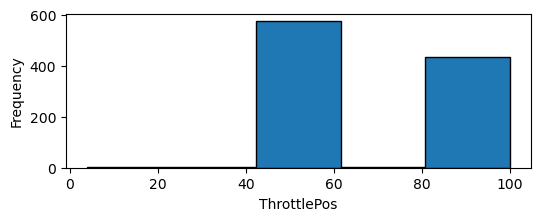

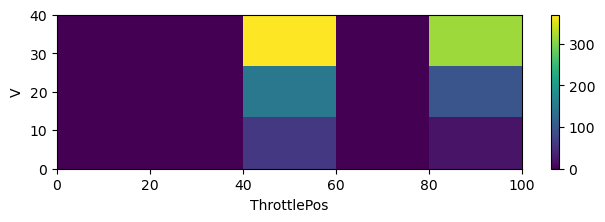

In [54]:
READ_Parameter_w_DCM(DCM)
df_RESULT = Change_Data_for_Evaluation(DIR_OUT, AX_OFFSET)
Plot_ThrottlePos_V(df_RESULT)

## DownSampling

original: 1013
donw sampling: 409


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_7532\2159649650.py:16: RuntimeWarning: divide by zero encountered in divide
  ratios = 1 - (ratios - ratio_min) / ratios


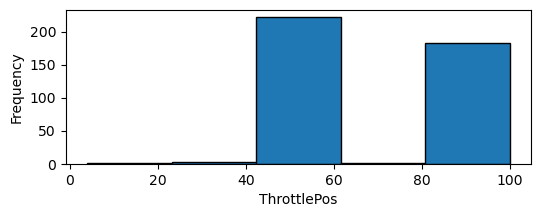

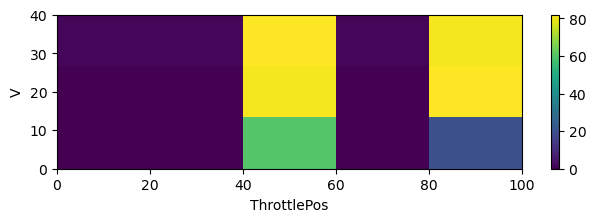

In [55]:
df_RESULT_ = DownSampling(df_RESULT, ratio_min=0.08)
Plot_ThrottlePos_V(df_RESULT_)

## Calculation Coeta

In [56]:
COETA_vWheel, COETA_Sensor = Calculation_Coeta(df_RESULT_)

Ax_vWheel:
coef_FA: 0.8591558222538931
coef_RA: 1.293871103654399
Ax_Sensor:
coef_FA: 0.8753745557393967
coef_RA: 1.4016472909252229


## Plot

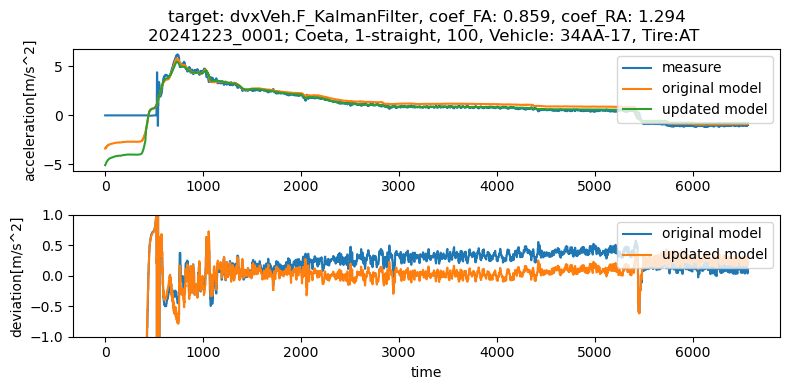

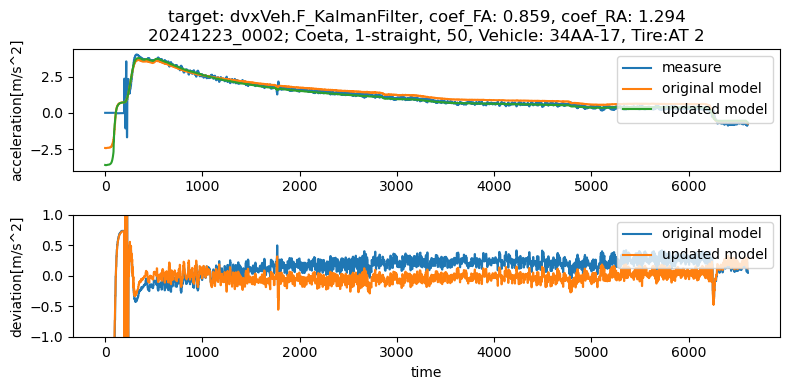

In [64]:
Ref_Model = ('vWheel', 'dvxVeh.F_KalmanFilter')
# coef_FA = 0.86
# coef_RA = 1.29
coef_FA = 0.859
coef_RA = 1.294


# Ref_Model = ('G-Sensor', 'ax')
# coef_FA = 1.11
# coef_RA = 0.82

for f in d_CSVs:
    file = d_CSVs[f][1]
    df = pd.read_table(file, sep=',')

    df['Ax_Model_updated'] = ((df['FxWheel_FA'] * coef_FA + df['FxWheel_RA'] * coef_RA) - df['airResistance']) / df['Mass']
    base_name = os.path.splitext(os.path.basename(f))[0]
    title = f'target: {Ref_Model[1]}, coef_FA: {coef_FA}, coef_RA: {coef_RA}' + '\n'
    title += f'{base_name}; {d_CSVs[f][0][:50]}'
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4))
    if Ref_Model[0] == 'G-Sensor':
        ax1.plot(df['Ax_Sensor'], label='measure')
    elif Ref_Model[0] == 'vWheel':
        ax1.plot(df['Ax_vWheel'], label='measure')
    ax1.plot(df['Ax_Model'], label='original model')
    ax1.plot(df['Ax_Model_updated'], label='updated model')
    # plt.hist(X, bins=5, edgecolor='black')
    # plt.title(f)
    # plt.xlabel('ThrottlePos')
    ax1.set_title(title)
    # ax1.set_xlabel('X axis')
    ax1.set_ylabel('acceleration[m/s^2]')
    ax1.legend(loc='upper right')
    
    # 2番目のグラフ
    # ax1.plot(df['Ax_Sensor'], label='Sensor')
    # ax1.plot(df['Ax_vWheel'], label='vWheel')
    if Ref_Model[0] == 'vWheel':
        ax2.plot(df['Ax_Model']-df['Ax_vWheel'], label='original model')
        ax2.plot(df['Ax_Model_updated']-df['Ax_vWheel'], label='updated model')
    elif Ref_Model[0] == 'G-Sensor':
        ax2.plot(df['Ax_Model']-df['Ax_Sensor'], label='original model')
        ax2.plot(df['Ax_Model_updated']-df['Ax_Sensor'], label='updated model')
    # ax2.set_title('Second Plot')
    # ax2.set_xlabel('X axis')
    ax2.set_ylim(-1, 1)
    ax2.set_ylabel('deviation[m/s^2]')
    ax2.set_xlabel('time')
    ax2.legend(loc='upper right')

    # グラフを表示
    plt.tight_layout()
    plt.show()

    fig.savefig(f'{Ref_Model[0]}_{base_name}.png')